In [11]:
import numpy as np
import matplotlib.pyplot as plt
import geometries as gm
import solver as sv
import problem as pm
from importlib import reload
reload(gm);
reload(sv);

In [63]:
fp = lambda s: s[::-1]

# Part 1: Introduction to the problem
## The problem
- Find the **optimal path and speeds** of a race car to complete a race track in **minimum time**.
- When driving around curves, the car must slow to avoid losing traction.
- The car has limited acceleration and braking ability (e.g cannot go from 50km/h to 250km/h in one second!).
- The car must stay on the pavement.
- Full knowledge of the track ahead is assumed





### Illustration of under-steering 
    

![Understeer](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Understeer-right-hand-drive.svg/200px-Understeer-right-hand-drive.svg.png)

    

source: [wikipedia](https://commons.wikimedia.org/wiki/File:Understeer-right-hand-drive.svg)





## Principle of optimal path
- Tight curves are slow, so the driver should try to smooth them by starting to turn before the bend in the road, and ending the turn after the bend (path 2 below)

- Use the maximum possible speed for each segment.

![bend](https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/222/2014/12/20102654/Figure_07_03_04a-350x474.jpg)

In [75]:
def draw_track_examples():
    fig, ax = plt.subplots(1,2, figsize=(20,8))

    tr = gm.compose_track(gm.turtlehead)
    gm.plot_segments(tr.segments,20,color='k-', ax=ax[0], show=False)
    tr = gm.compose_track(gm.lionhead)
    gm.plot_segments(tr.segments,20,color='k-',ax=ax[1], show=False)
    ax[0].set_title('"בצ שאר"', fontsize=20)
    ax[1].set_title('"הירא שאר"',fontsize=20);
    ax[0].text(0,10,"start",fontsize=12)
    ax[0].text(70,-60,"finish",fontsize=12)
    ax[0].set_xlabel(fp("מטרים"),fontsize=14)
    ax[0].set_ylabel(fp("מטרים"),fontsize=14)
    ax[1].text(0,20,"start",fontsize=12)
    ax[1].text(300,-100,"finish",fontsize=12)
    ax[1].set_xlabel(fp("מטרים"),fontsize=14)
    ax[1].set_ylabel(fp("מטרים"),fontsize=14)


## Example tracks
- Each plot below shows a different track's centerline
- These tracks are made up, with reasonable scales and curves for use by "normal cars"

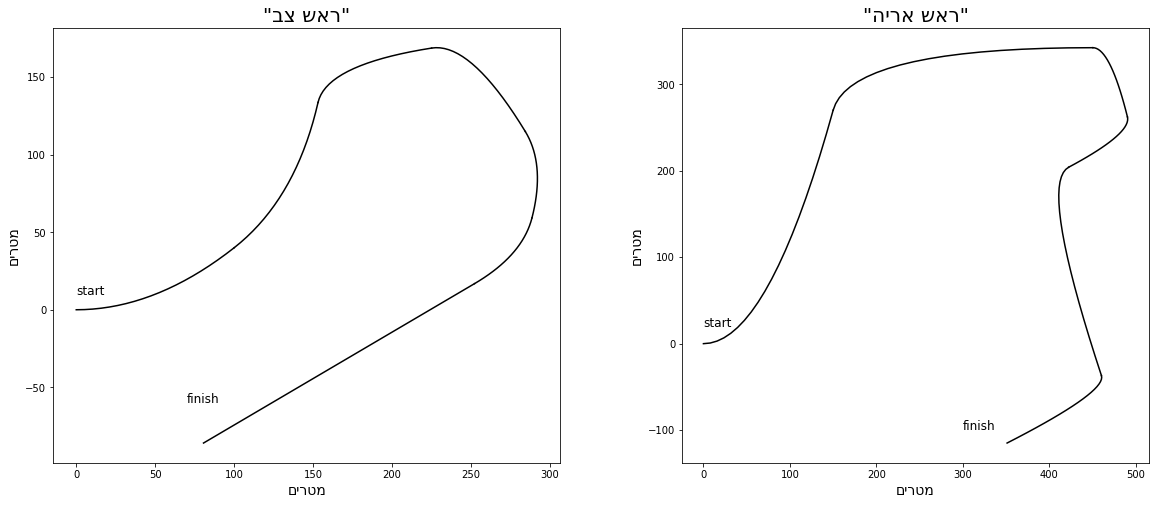

In [76]:
draw_track_examples()


## Example solution path
- The blue dotted line represents the car's path
- The deviations are exaggerated for illustration purposes
- As expected, the chosen path "smoothes" the turns

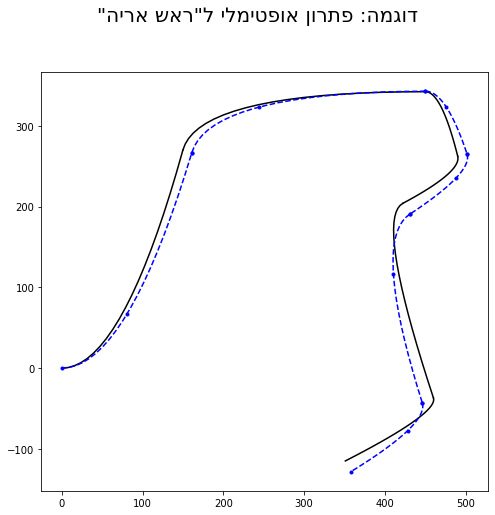

In [79]:
fig = plt.figure(figsize=(8,8))
fig.suptitle(fp('דוגמה: פתרון אופטימלי ל"ראש אריה"'),fontsize=20)
sv.test_solver()


# Part 2: Details of geometric representation
## Choosing piecewise parabolic segments as the main geometric representation 

The geometric representation allows to describe the geometric entities (track's shape, car path's shape), using  parameters. These parameters are needed to formulate the optimization problem.  

I use parabola segments. This is a simple representation, which can be made C1-continuous. It is useful for representing the track's centerline, as well as the car path's shape.

Recall that a parabola in the plane has 4 parameters. In analytical geometry, a parabola is defined by the (x,y) coordinates of the _focus_ and the 2 parameters describing the _directrix_ (a straight line). However if we "start" with the family of parabolas $y=ax^2$, by translation and rotation in the plane we can to obtain any parabola (i.e. any focal point and directrix). 

## Parametric representation of a parabolic segment
List of parameters:
- $a$, the parabola's curvature
- $(x_o,y_o)$, the amount of shift relative to the origin (offset)
- $\theta$, the amount of rotation.
- $s$, the "length" of the segment. More accurately, it is the maximum $x$ value (before shift and rotation). The minimum x value is always 0.

The parametric equations of the "basic" parabola are
$$x=mt\\y=as^2t^2\\0 \le t \le 1$$

The parametric equations with rotation and shift:
$$x=x_o + st\cos \theta - as^2t^2 \sin \theta\\
y=y_o + st \sin \theta + as^2t^2 \cos \theta$$






## C1 continuity conditions 
For a path composed piecewise of segments to be C1 continious, two conditions must hold:
- Each segment (except the first) should start at the end point of the previous
- The direction (derivative) of each segment, at its leftmost point, should math that of the previous, at its rightmost point.

Since the location and rotation in the plane of the track as a whole do not matter, we (arbitrarily) set the first path segment to rotation and translation 0. Each subsequent path's translation and rotation are determined by the two continuity equation relative to the one before. This means that **the two vectors $a=(a_1,\ldots a_N)$ and $m=(m_1,\ldots m_N)$ uniquely determine the path.**

The equations are as follows:
#### c0: 

$$x_{o(i)} + s_i\cos \theta_i - as_i^2 \sin \theta_i = x_{o(i+1)}\\
y_{o(i)} + s_i \sin \theta_i + as_i^2 \cos \theta_i = y_{o(i+1)}$$

### c1:
$$\theta_i + \tan^{-1}\frac{dy}{dx}|_{x=s_i} = \theta_{i+1}\\
\Downarrow\\
\theta_i + \tan^{-1}2a_is_i= \theta_{i+1}$$




# Part 3: Background on physical considerations 
## 1. Traction 
For each section of the track, there is an associated parameter &mu; which represents the traction (i.e. friction between the track and tires). In our problem I assumed &mu; to be constant for all segments.

The theory of circular motion states that radial Force $F_r$ is given by 
$$F_r=M\frac{V^2}{R}$$
On the other hand, the maximum force provided by friction is 
$$F_\mu \le Mg\mu$$
Substituting yields
$$V^2 \le \mu g R$$

Since our decision variables are the speeds at the knots, we apply two constraints to each of the speed decision variables - one for the segment it just left and one for the segment it is just entering (equivalently we just need to choose the stricter one).

## 2. Turn radius
The radius of a twice-differentiable curve is given (locally) by 
$$R = \frac{(1+(\frac{dy}{dx})^2)^{3/2}}{|\frac{d^2y}{dx^2}|}$$

For a parabola $y=ax^2$ the radius at $x=0$ is $R=\frac{2}{|a|}$. We will use this approximation for the radius at the beginning of each segment. The value at the end of the segment is approximated to be 20% larger,  $\frac{2.4}{|a|}$. Note that the larger the radius, the faster the car can travel. A straight line has a radius of &infin;.

## 3. Accelaration
The following formula relates the speeds $V_0$ and $V_t$, at the beginning and end of a segment respectively, with the segment length $s$ and the constant acceleration $e$ in the segment:
$$V_t^2-V_0^2 = 2es$$


# Part 4: Details of the problem formulation
## The decision variables
The decision variables should represent the speed of the car and the steering inputs along the path. The _state_ of the car consists of its speed, its orientation (angle of the car's axis with the track's centerline) and its lateral position on the track (distance from track's centerline). Note that if the orientation is known at every point, the the lateral position can be calculated from it. 

I made the following design choices:
* The decision variables specify the state at the knots (joints between the parabolic segments). The state within each segment can be inferred by interpolation.
* The initial state (i.e. at the beginning of the first track segment) is predetermined. In other words, the car's speed, position and orientation at the starting point of the track are known (and therefore not optimized). Note that the speed is not zero. 
* The car is assumed to have a constant accelaration (i.e. linear speed) and a constant steering angle (turn radius) within each track segment.
* The decision variables represent deviations from a _nominal_ set of speeds and steering inputs.

Therefore, for a track of $N$ parabolic segments, a total of $2N$ decision variables are required. They represent the speeds and lateral position at the end of each segment. They fully represent the turning and engine/brake decisions of the driver.


## "Nominal" solution 
A nominal solution is one that is both a "default" solution and "good enough" for the given track. For the race track problem, the nominal solution is:
* Set the car's path to the centerline of the track
* Calculate speeds - based on the traction limit for the give path segments, and other considerations (see below).

Once the nominal solution is obtained, the decision variables are defined _relative to the nominal_ as follows:
* The speed at each knot is $V_i = m_i(1+u_i)$ where $m_i$ is the nominal speed and $u_i$ is the decision variable.
* The lateral position of the car at the knot is $d_i$, where $d_i=0$ represents the car being positioned on the centerline, $d_i \gt 0$ is a deviation towards the left and $d_i \lt 0$ is a deviation towards the right.

A candidate solution is $\vec{x} = (u_0,\ldots,u_{N-1},d_0,\ldots,d_{N-1})$

Using this representation, $\vec{x}_{nominal}=\vec{0}$. This makes the problem similar in formulation to control problems.




## Details of the constraints affecting the nominal solution

1. The speed of the car at the _beginning_ of each track segment, is bounded by $$\frac{m_i^2}{R_{i+1}} \le \mu$$.
1. The speed of the car at the _end_ of each track segment is bounded by $$\frac{m_i^2}{R_{i}} \le 1.2 \mu$$ 

1. The difference between two consecute speeds is bounded by an acceleration parameter $e$ and a braking parameter $b$ (together with the segment's length): $-2 \cdot b \cdot s_{i+1} \le m_{i+1}^2-m_i^2 \le 2 \cdot e \cdot s_{i+1}$
1. The speeds must be below the car's top speed: $m_i^2 \le V_{\max}^2$
1. All speeds are positive.

### Algorithm for calculating the nominal solution
1. Set $R_i = \frac{2}{a_i}$. 
1. $m_i^2 \leftarrow \min\{\mu \cdot R_{i+1}, V_{\max}^2 \}$
1. $m_i^2 \leftarrow \min\{m_i^2, m_{i-1}^2+2\cdot e \cdot s_{i+1}, m_{i+1}^2+2\cdot b \cdot s_{i}\}$
1. repeat step 3 until no change to any $m_i^2$
1. Take the square root to get $m_i$



# Part 5: the optimization
## Optimization process overview
When a problem is given, the code first calculates the nominal solution as described above.
Then, the optimization matrices $H$ and $F$ are calculated. The optimization is QP (quadratic goal with linear constraints). The solution is calculated using the conjugate gradient method. KKT conditions are used to optimize with constraints. A heuristic is used to determine which boundary (box) constraints are necessary.

## Goal

The goal of the optimization is $\min \sum t_i = \sum \frac{s_i}{V_i}$, where $s_i$ is the given segment length and $V_i = \frac{1}{2}(m_i (1+u_i) + m_{i+1} (1+u_{i+1}))$ is the averge speed within the segment.

This goal is fairly well approximated for $$-\frac{1}{2} \le u_i \le \frac{1}{2}$$
By $$\sum t_i = \frac{2s_{i+1}}{m_i+m_{i+1}}\frac{1}{1+\bar{u_i}} \approx \sum_i \frac{2s_{i+1}}{m_i+m_{i+1}}(1-\bar{u_i}+\bar{u_i}^2)$$
Where
$$\bar{u_i} = \beta u_i + (1-\beta)u_{i+1}\\ \beta=\frac{m_i}{m_i+m_{i+1}}$$

The important thing to note is that this approximation is useful in ensuring a convex objective.


## Radial accelaration constraint

The constraint is linearized as follows:

Original expression: $$\frac{V_i^2}{|R_i|} \le \mu\\$$

Using $K=1/R$ and linearizing in $u_i$ and $\Delta k$ we obtain 
Linearized: $$2u_i+\frac{1}{k_i}\sum_j \Delta k_{ij} d_j + (1- \frac{\mu}{m_i^2 k_i}) \le 0$$



$\Delta k_{ij}$ is the transformation matrix from the path's geometry decision variables (expressed as deviations from track's centerline) to the change in the curvatures of the $i$'s segment of the car's path. 



## Bound constraints
The bound constraints on the $u_i$'s and $d_i$ are:
$$\forall i,\ -\frac{1}{2} \le u_i \le \frac{1}{2}\
\forall i,\ -4 \le d_i \le 4\$$

The $u_i$ are dimensionsless deviations from the nominal speed. The $d_i$ are in units of length (meters).

Each pair of bound constraints is colinear and so cannot be used at the same time. Therefore, the optimization is first carried out with just the radial accelaration constraints. Then, bound constraints are added based on the last optimization run result, until all variables are actively constrained or within their bounds.



## Numerical solution process
The problem is quadratic, with linear inequality constraints. This means that the KKT multipliers can be added into the formulation.
A stationary solution vector of the quadratic problem $x^THx+Fx$ is found by solving the linear system $Hx+F=0$. In my code, I use the conjugate gradient algorithm. Extensive testing showed that even when the problem is not convex, this algorithm finds the correct solution.

I added a small quadratic coefficient to all the decision variables. This induces numerical stability and ensures "perference" for small deviations. The quadratic coefficients are small so they don't affect the solution noticeably.

### Solution procedure
1. Find the nominal speeds using the _nominal speed algorithm_ described above
2. Construct the problem matrices. At this stage they "include" just the objective and the radial accelaration constraints.
3. Solve using conjugate gradient method
4. Remove any constraint whose KKT multiplier is less than 0.
5. repeat Step 4 until all multipliers are positive
6. If all $u_i$ and $d_i$ (the speed and path decision variables) are within bounds, return the solution and exit
7. Choose one constraint from the ones currently violated. Add it to the problem formulation
8. Go back to step 4, repeat this loop until the test in step 6 passes (i.e. a valid solution is obtained)


# Part 6: Plotting some results
### Example 1

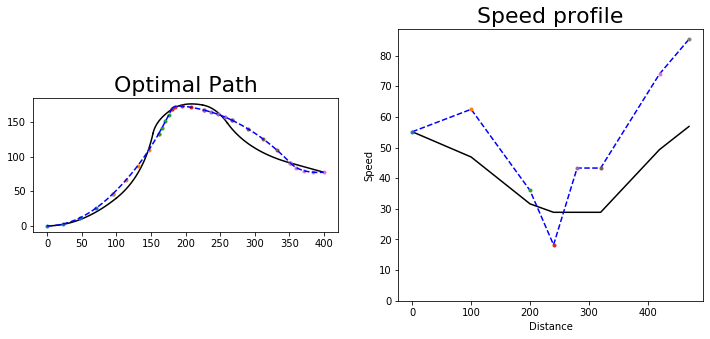

In [46]:
reload(gm);
reload(sv);
plt.figure(figsize=(12,5))
sv.solve_using_boundaries(prob=sv.make_problem(gm.hillshape, mu=1),plot_solution=True, trace_mult=2,su=1000);


This simple track demonstrates how the optimzation works. 

**Left:** The track (solid black) and the path traced by the car (dashed blue). Note that the optimization "focused" the turn into one segment, and smoothed out the rest of the path

**Right:** Speed profile. Nominal speed (solid black) and optimal speed enabled by the smoothed path (dashed blue). Note the nominal speed is slower, except at one point where the car performs most of the turning. There are some constraints applied to the nominal speed, which are not implemented for the optimal speed, which also explains why the optimal speed can be higher



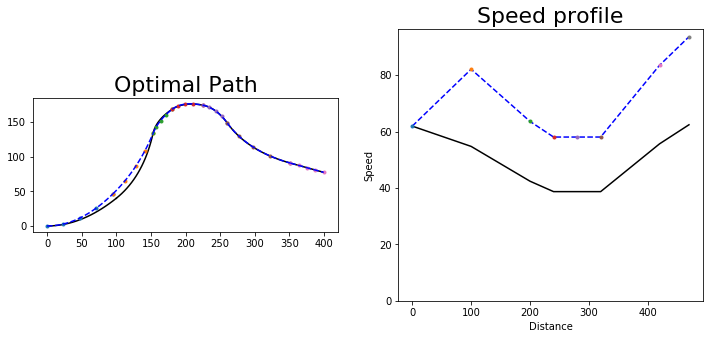

In [47]:
plt.figure(figsize=(12,5));
sv.solve_using_boundaries(prob=sv.make_problem(gm.ushape, mu=1.8),plot_solution=True,trace_mult=2,su=100);


### Example 2
The mu parameter was increased. due to the added traction, the deviations from the centerline are smaller, while the speed is not limited by radia forces

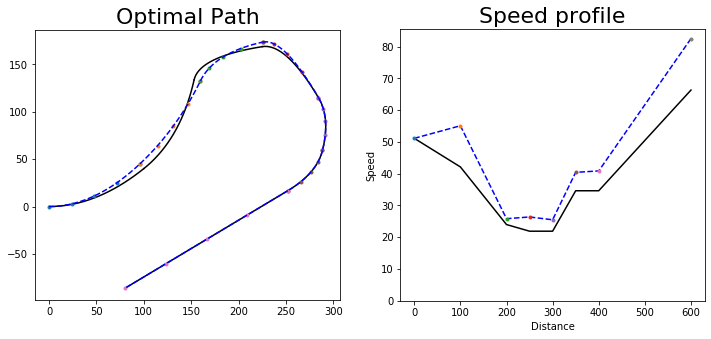

In [119]:
plt.figure(figsize=(12,5));
sv.solve_using_boundaries(prob=sv.make_problem(gm.turtlehead, mu=1.2),plot_solution=True,trace_mult=2,su=10000);


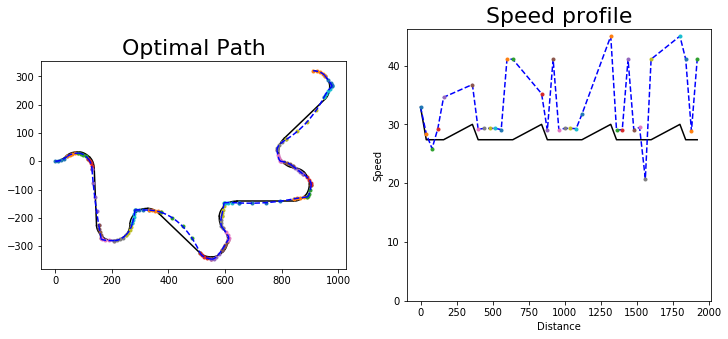

In [115]:
reload(gm)
reload(pm)
plt.figure(figsize=(12,5));
sv.solve_using_boundaries(prob=sv.make_problem(gm.zigzag, mu=0.9),plot_solution=True,trace_mult=2,su=20000);


This path has a repeating pattern of left turn, straight strech, right turn. The optimization uses the longer straight segment to complete the turn more gradually.

# Summary
An optimization problem involving geometric entities and a kinematic problem was solved. 
The optimization was formulated as a quadratic programming problem and solved by exploiting KKT conditions.
A "focusing" behavior was observed, where the system "prefers" short sections with sharp turns to allow the rest of the sections to be smoother. The issues of finding the active set and colinear constraints were tackled. 